In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json, yaml
import glob, os

from lienp.SE3 import SE3, se3

data_dir = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir)) + "/data"
image_dir = f"{os.path.expanduser('~')}/data/record2"

images = glob.glob(f'{image_dir}/*.jpg')
images = np.sort(images)
with open(f'{data_dir}/camera_calib_test2.json', 'r') as fs:
    mocap_data = json.load(fs)

# blobs_dict = {int(key): np.array(val) for key,val in blobs_dict.items()}
mocap_data.keys()

dict_keys(['Name', 'MeasurementCreation', 'ExportTime', 'User', 'QtmVersion', 'CurrentFrame', 'TraceRange', 'Timebase', 'Markers', 'Bones', 'RigidBodies', 'Timecode'])

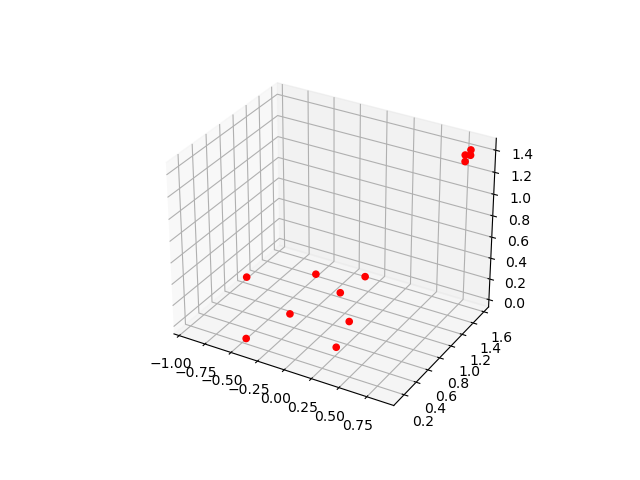

In [3]:
rbs_dict = mocap_data['RigidBodies']
markers_dict = mocap_data['Markers']

markers_pos = np.array([markers_dict[i]['Parts'][0]['Values'] for i in range(len(markers_dict))])
markers_pos = np.mean(markers_pos, axis=1)/1000

target_marker_pos = markers_pos[4:12]
target_marker_pos = target_marker_pos[:,0:3].T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(markers_pos[:,0], markers_pos[:,1], markers_pos[:,2], color='r', alpha=1)
ax.set_aspect('equal')

In [4]:
def find_blob(frame, detector):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    keypoints = detector.detect(frame)
    # Draw blobs
    blank = np.zeros((1, 1))
    img_blobs = cv2.drawKeypoints(frame, keypoints, blank, (255, 0, 0),
                            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # blobs_ = cv2.undistort(blobs, K.reshape(3,3), cam_dist, None, newCameraMatrix=K_opt)
    # text = "Number of Circular Blobs: " + str(len(keypoints))
    # cv2.putText(img_blobs, text, (20, 20),
    #             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 5)
    blobs = np.array([kp.pt for kp in keypoints], dtype=float)
    return blobs, img_blobs

In [5]:
info_dir = os.path.abspath( os.path.join(os.path.dirname(''), os.pardir)) + "/camera_info/"
with open(f'{info_dir}/camera_0.yaml', 'r') as fs:
    cam_info = yaml.safe_load(fs)
K = np.array(cam_info["camera_matrix"]["data"])
cam_dist = np.array(cam_info["distortion_coefficients"]["data"])
K_opt, dist_valid_roi = cv2.getOptimalNewCameraMatrix(K.reshape(3,3), cam_dist, (1600,1200), 1, (1600, 1200))

R_model2cam = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],        
])

# SE2, transform image coordiantes to match the book
SE2_pix2image = np.array([
    [-1, 0,  1600],
    [0, -1, 1200],
    [0, 0,  1],
])

K_ = SE2_pix2image @ K_opt @ R_model2cam

K_t = np.block([
    [K_, np.zeros((3,1))],
    ])

In [6]:

# undistort_img = cv2.undistort(img, K.reshape(3,3), cam_dist, None, newCameraMatrix=K_opt)
# undistort_points = cv2.undistortPoints(np.expand_dims(points, axis=1), K.reshape(3,3), cam_dist, P=K_opt)

# Initialize parameter setting using cv2.SimpleBlobDetector
# Set our filtering parameters
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 100
params.maxThreshold = 255

params.filterByColor = True
params.blobColor = 255

# Set Area filtering parameters
params.filterByArea = True
params.minArea = 20
params.maxArea = 150
  
# Set Circularity filtering parameters
params.filterByCircularity = True 
params.minCircularity = 0.5
  
# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.8
      
# Set inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.2
  
# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

img = cv2.imread(images[0])
blobs, img_blobs = find_blob(img, detector)
blobs_undistort = np.squeeze(cv2.undistortPoints(np.expand_dims(blobs, axis=1), K.reshape(3,3), cam_dist, P=K_opt))

In [8]:
c_mocap = np.array(rbs_dict[0]['Parts'][0]['Values'][0][0])[0:3] / 1000
R_mocap = np.array(rbs_dict[0]['Parts'][0]['Values'][0][1]).reshape((3,3))
T_mocap = SE3(R=R_mocap, c=c_mocap)
target_marker_pos_h = np.vstack([target_marker_pos, np.ones(target_marker_pos.shape[1])])
target_marker_pos_h
blobs_proj_h = K_t @ T_mocap.M @ target_marker_pos_h
blobs_proj = blobs_proj_h[0:2,:] / blobs_proj_h[2,:]
blobs_proj.shape

(2, 8)

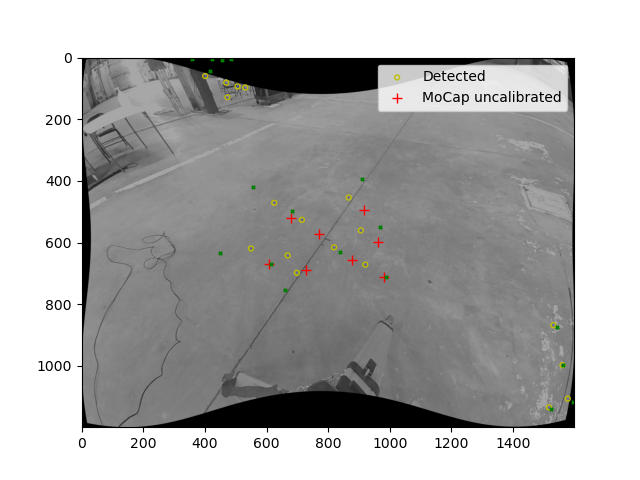

In [17]:
undistort_img = cv2.undistort(img_blobs, K.reshape(3,3), cam_dist, None, newCameraMatrix=K_opt)
# undistort_points = cv2.undistortPoints(np.expand_dims(points, axis=1), K.reshape(3,3), cam_dist, P=K_opt)
fig = plt.figure()
ax = fig.add_subplot()
img_rgb = cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB)
ax.imshow(img_rgb)
ax.scatter(blobs_undistort[:,0], blobs_undistort[:,1], marker='.', s=50, facecolor='none', edgecolors='y', linewidths=1, label='Detected')
ax.scatter(blobs_proj[0,:], blobs_proj[1,:], marker='+', s=50, c='r', linewidths=1, label='MoCap uncalibrated')
# ax.scatter(blobs[:,0], blobs[:,1], marker='x', s=5, color='g')
ax.legend()

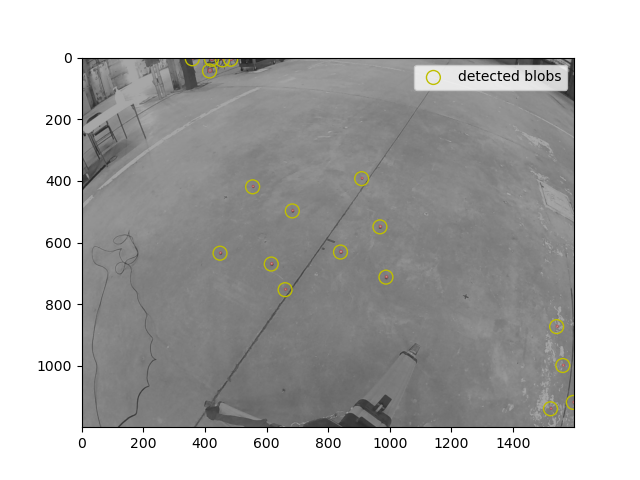

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
img_rgb = cv2.cvtColor(img_blobs, cv2.COLOR_BGR2RGB)
ax.imshow(img_blobs)
ax.scatter(blobs[:,0], blobs[:,1], s=100, facecolor='none', edgecolors='y', label='detected blobs')
ax.legend()

In [ ]:
# blobs_undistort_clean = blobs_undistort[]

blobs_undistort_clean = blobs_undistort[np.bitwise_and(blobs_undistort[:,1] < 850, blobs_undistort[:,1] > 350)]
blobs_undistort_clean.shape

(9, 2)

In [ ]:
from probreg import cpd, filterreg, callbacks, transformation
import open3d as o3
import copy

target = o3.geometry.PointCloud()
target.points = o3.utility.Vector3dVector(np.hstack([blobs_undistort_clean, np.zeros((blobs_undistort_clean.shape[0],1))]))
source = o3.geometry.PointCloud()
source.points = o3.utility.Vector3dVector(np.hstack([blobs_proj.T, np.zeros((blobs_proj.T.shape[0],1))]))

result = copy.deepcopy(source)
tf_param, _, _ = cpd.registration_cpd(source, target)
result.points = tf_param.transform(result.points)

source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
